<a href="https://colab.research.google.com/github/s34836/WUM/blob/main/Lab_11_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning
## Example

In [ ]:
!tar -xzf imagenette2.tgz

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

image_size = (224, 224)
batch_size = 32

(train_ds, val_ds), ds_info = tfds.load(
    "cats_vs_dogs",
    split=["train[:80%]", "train[80%:]"],
    as_supervised=True,
    with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.TZORRT_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [ ]:
preprocess = tf.keras.applications.mobilenet_v2.preprocess_input

def prepare(image, label):
    image = tf.image.resize(image, image_size)
    image = preprocess(image)
    return image, label

train = (
    train_ds
    .map(prepare, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(1000)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

valid = (
    val_ds
    .map(prepare, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
image_shape = (224, 224, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=image_shape,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=image_shape),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss="binary_crossentropy", metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
model.fit(train, validation_data=valid, batch_size=32, epochs=3)

Epoch 1/3
582/582 ━━━━━━━━━━━━━━━━━━━━ 95s 131ms/step - accuracy: 0.9729 - loss: 0.0754 - val_accuracy: 0.9877 - val_loss: 0.0429
Epoch 2/3
582/582 ━━━━━━━━━━━━━━━━━━━━ 49s 81ms/step - accuracy: 0.9895 - loss: 0.0360 - val_accuracy: 0.9869 - val_loss: 0.0511
Epoch 3/3
582/582 ━━━━━━━━━━━━━━━━━━━━ 44s 72ms/step - accuracy: 0.9914 - loss: 0.0262 - val_accuracy: 0.9908 - val_loss: 0.0447


## Tasks
1. Use one of the pretrained models available in Tensorflow to classiy images in the `imagenette2` dataset. See the list of available models [here](https://keras.io/api/applications/).
2. (optional) Fine-tune the pretrained model. Unfreeze the last few convolutional layers of the model trained in Task 1 by setting `trainable=True`. Then recompile the model and train it for a few more epochs with a low learning rate.

In [ ]:
# 1. Use one of the pretrained models available in Tensorflow to classiy images
# in the imagenette2 dataset. See the list of available models here.
# używam mobilenet_v2


# --- ustawienia
image_size = (224, 224)
batch_size = 32
train_dir = "imagenette2/train"
val_dir   = "imagenette2/val"

# --- generatory (preprocess POD MobileNetV2)
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)
val_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_ds = train_gen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",  # Imagenette ma 10 klas
    shuffle=True
)

val_ds = val_gen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

# --- pretrained backbone
base = tf.keras.applications.MobileNetV2(
    input_shape=(image_size[0], image_size[1], 3),
    include_top=False,
    weights="imagenet"
)
base.trainable = False  # najpierw trenujemy tylko head

# --- model
inputs = tf.keras.Input(shape=(image_size[0], image_size[1], 3))
x = base(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(train_ds.num_classes, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(train_ds, validation_data=val_ds, epochs=5)

# (optional) Fine-tune the pretrained model. Unfreeze the last few convolutional
# layers of the model trained in Task 1 by setting trainable=True.
#Then recompile the model and train it for a few more epochs with a low learning rate.
base.trainable = True
for layer in base.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_ft = model.fit(train_ds, validation_data=val_ds, epochs=5)

Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 84s 254ms/step - accuracy: 0.8361 - loss: 0.5756 - val_accuracy: 0.9868 - val_loss: 0.0528
Epoch 2/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 48s 162ms/step - accuracy: 0.9887 - loss: 0.0419 - val_accuracy: 0.9903 - val_loss: 0.0382
Epoch 3/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 47s 160ms/step - accuracy: 0.9935 - loss: 0.0276 - val_accuracy: 0.9883 - val_loss: 0.0377
Epoch 4/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 47s 158ms/step - accuracy: 0.9965 - loss: 0.0169 - val_accuracy: 0.9896 - val_loss: 0.0333
Epoch 5/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 47s 160ms/step - accuracy: 0.9965 - loss: 0.0150 - val_accuracy: 0.9898 - val_loss: 0.0332
Epoch 1/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 83s 226ms/step - accuracy: 0.9841 - loss: 0.0575 - val_accuracy: 0.9896 - val_loss: 0.0321
Epoch 2/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 49s 164ms/step - accuracy: 0.9895 - loss: 0.0390 - val_accuracy: 0.9898 - val_loss: 0.0320
Epoch 3/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 48s 161ms/step - accuracy: 0.9925 - loss: 0.0259 - 

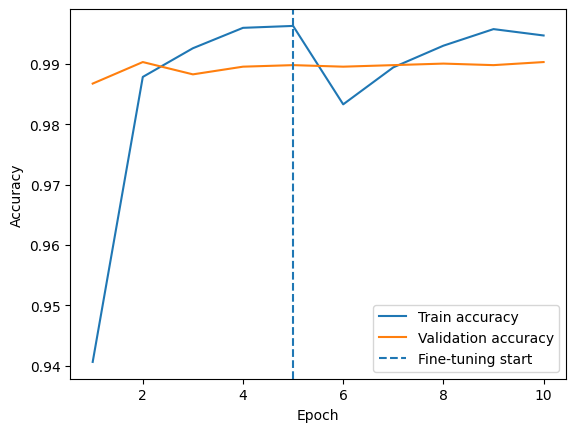

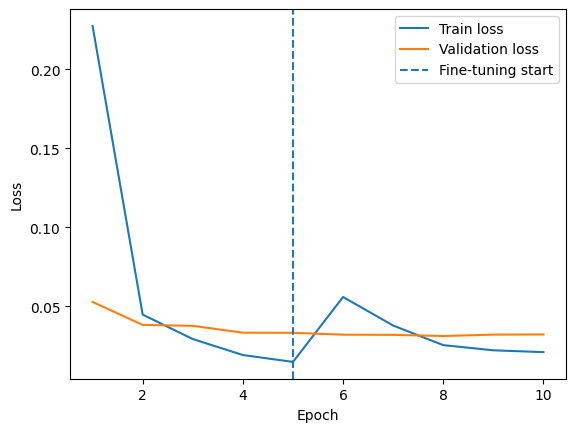

In [ ]:
import matplotlib.pyplot as plt

# --- zepnij historie w jedną oś epok
acc = history.history["accuracy"] + history_ft.history["accuracy"]
val_acc = history.history["val_accuracy"] + history_ft.history["val_accuracy"]

loss = history.history["loss"] + history_ft.history["loss"]
val_loss = history.history["val_loss"] + history_ft.history["val_loss"]

epochs = range(1, len(acc) + 1)

# --- accuracy
plt.figure()
plt.plot(epochs, acc, label="Train accuracy")
plt.plot(epochs, val_acc, label="Validation accuracy")
plt.axvline(len(history.history["accuracy"]), linestyle="--", label="Fine-tuning start")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# --- loss
plt.figure()
plt.plot(epochs, loss, label="Train loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.axvline(len(history.history["loss"]), linestyle="--", label="Fine-tuning start")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# 1. Use one of the pretrained models available in Tensorflow to classiy images
# in the imagenette2 dataset. See the list of available models here.
# używam efficientnet_v2

# --- ustawienia
image_size = (224, 224)
batch_size = 32
train_dir = "imagenette2/train"
val_dir   = "imagenette2/val"

# --- generatory (preprocess POD EfficientNetV2)
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input
)
val_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input
)

train_ds = train_gen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",  # Imagenette ma 10 klas
    shuffle=True
)

val_ds = val_gen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

# --- pretrained backbone
base = tf.keras.applications.EfficientNetV2B0(
    input_shape=(image_size[0], image_size[1], 3),
    include_top=False,
    weights="imagenet"
)
base.trainable = False  # najpierw trenujemy tylko head

# --- model
inputs = tf.keras.Input(shape=(image_size[0], image_size[1], 3))
x = base(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(train_ds.num_classes, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(train_ds, validation_data=val_ds, epochs=5)

# (optional) Fine-tune the pretrained model. Unfreeze the last few convolutional
# layers of the model trained in Task 1 by setting trainable=True.
#Then recompile the model and train it for a few more epochs with a low learning rate.

base.trainable = True
for layer in base.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_ft = model.fit(train_ds, validation_data=val_ds, epochs=5)

Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 106s 260ms/step - accuracy: 0.8832 - loss: 0.5706 - val_accuracy: 0.9939 - val_loss: 0.0344
Epoch 2/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 48s 162ms/step - accuracy: 0.9939 - loss: 0.0330 - val_accuracy: 0.9946 - val_loss: 0.0223
Epoch 3/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 49s 166ms/step - accuracy: 0.9962 - loss: 0.0174 - val_accuracy: 0.9954 - val_loss: 0.0188
Epoch 4/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 47s 159ms/step - accuracy: 0.9964 - loss: 0.0134 - val_accuracy: 0.9964 - val_loss: 0.0172
Epoch 5/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 48s 161ms/step - accuracy: 0.9965 - loss: 0.0108 - val_accuracy: 0.9967 - val_loss: 0.0159
Epoch 1/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 102s 242ms/step - accuracy: 0.9956 - loss: 0.0304 - val_accuracy: 0.9936 - val_loss: 0.0267
Epoch 2/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 48s 160ms/step - accuracy: 0.9952 - loss: 

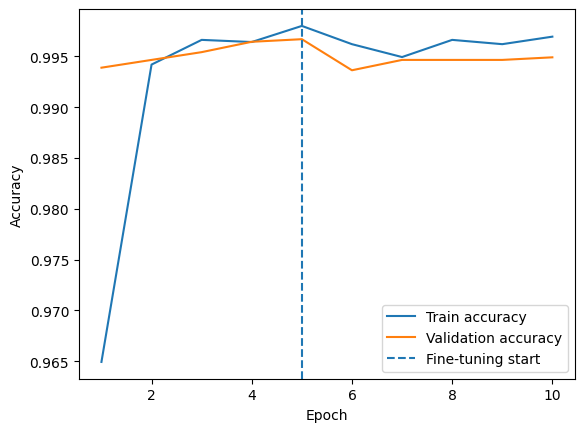

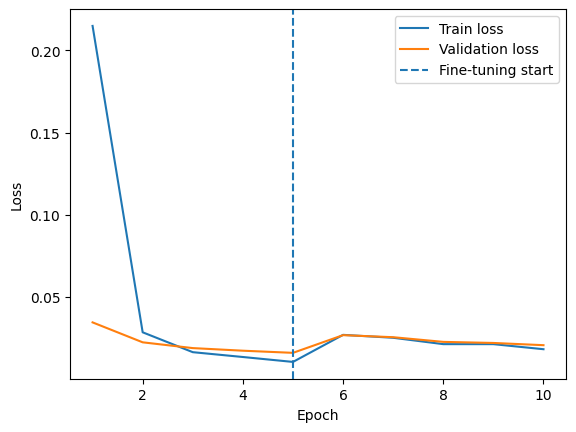

In [ ]:
import matplotlib.pyplot as plt

# --- zepnij historie w jedną oś epok
acc = history.history["accuracy"] + history_ft.history["accuracy"]
val_acc = history.history["val_accuracy"] + history_ft.history["val_accuracy"]

loss = history.history["loss"] + history_ft.history["loss"]
val_loss = history.history["val_loss"] + history_ft.history["val_loss"]

epochs = range(1, len(acc) + 1)

# --- accuracy
plt.figure()
plt.plot(epochs, acc, label="Train accuracy")
plt.plot(epochs, val_acc, label="Validation accuracy")
plt.axvline(len(history.history["accuracy"]), linestyle="--", label="Fine-tuning start")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# --- loss
plt.figure()
plt.plot(epochs, loss, label="Train loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.axvline(len(history.history["loss"]), linestyle="--", label="Fine-tuning start")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive/Colab Notebooks"

 06_niedouczenie_vs_przeuczenie.ipynb
'Kopia notatnika Lab 08 - Regularization.ipynb'
'Kopia notatnika Lab 11 - Transfer Learning (1).ipynb'
'Kopia notatnika Lab 11 - Transfer Learning.ipynb'
'Kopia notatnika lab2.ipynb'
'Kopia notatnika lab4 (1).ipynb'
'Kopia notatnika lab4.ipynb'
'Kopia notatnika Untitled4 (1).ipynb'
'Kopia notatnika Untitled4.ipynb'
'Kopia notatnika Untitled5.ipynb'
'Lab 01 - Tensorflow examples.ipynb'
'Lab 06 - Convolutional Networks.ipynb'
'Lab 07 - Convolutional Networks 2.ipynb'
'Lab 08 - Regularization.ipynb'
 lab10.ipynb
'Lab 10 - Recurrent Networks 2.ipynb'
 lab11.ipynb
'Lab 11 - Transfer Learning_clean.ipynb'
'Lab 11 - Transfer Learning.ipynb'
 lab12.ipynb
 lab2.ipynb
 lab4.ipynb
 lab5.ipynb
 lab7-8.ipynb
 lab7-b.ipynb
'lab9 (1).ipynb'
 lab9.ipynb
'Lab - Clustering.ipynb'
'Lab - Data 2.ipynb'
'Lab - Data (bonus).ipynb'
'Lab - Data.ipynb'
'Lab - Linear Regression.ipynb'
'Lab - Modelling.ipynb'
'Lab - Model Selection, Regularization.ipynb'
'Lab - Trees (1) 1.i

In [ ]:
import json

in_path = "/content/drive/MyDrive/Colab Notebooks/Lab 11 - Transfer Learning.ipynb"
out_path = "/content/drive/MyDrive/Colab Notebooks/Lab 11 - Transfer Learning_clean.ipynb"

with open(in_path, "r", encoding="utf-8") as f:
    nb = json.load(f)

nb.get("metadata", {}).pop("widgets", None)

with open(out_path, "w", encoding="utf-8") as f:
    json.dump(nb, f, ensure_ascii=False, indent=1)

print("Saved:", out_path)

Saved: /content/drive/MyDrive/Colab Notebooks/Lab 11 - Transfer Learning_clean.ipynb
